In [15]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from pprint import pprint as pp
import csv
from pathlib import Path
import seaborn as sns
from itertools import product
import string

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import homogeneity_score, silhouette_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans, DBSCAN

In [17]:
df = pd.read_csv('creditcard.csv')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [19]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [20]:
# Count the occurrences of fraud and no fraud and print them
occ = df['Class'].value_counts()
occ

0    284315
1       492
Name: Class, dtype: int64

In [21]:
# Print the ratio of fraud cases
ratio_cases = occ/len(df.index)
print(f'Ratio of fraudulent cases: {ratio_cases[1]}\nRatio of non-fraudulent cases: {ratio_cases[0]}')

Ratio of fraudulent cases: 0.001727485630620034
Ratio of non-fraudulent cases: 0.9982725143693799


# Preprocessing Data

In [25]:
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    """
    Convert the DataFrame into two variable
    X: data columns (V1 - V28)
    y: lable column
    """
    X = df.iloc[:, 2:30].values
    y = df.Class.values
    return X, y

# Plotting

In [22]:
# Define a function to create a scatter plot of our data and labels
def plot_data(X: np.ndarray, y: np.ndarray):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()

In [23]:
def compare_plot(X: np.ndarray, y: np.ndarray, X_resampled: np.ndarray, y_resampled: np.ndarray, method: str):
    plt.subplot(1, 2, 1)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title('Original Set')
    plt.subplot(1, 2, 2)
    plt.scatter(X_resampled[y_resampled == 0, 0], X_resampled[y_resampled == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X_resampled[y_resampled == 1, 0], X_resampled[y_resampled == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title(method)
    plt.legend()
    plt.show()

In [26]:
# Create X and y from the prep_data function 
X, y = prep_data(df)

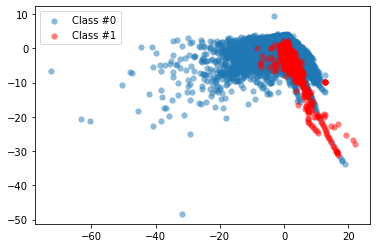

In [27]:
# Plot our data by running our plot data function on X and y
plot_data(X, y)

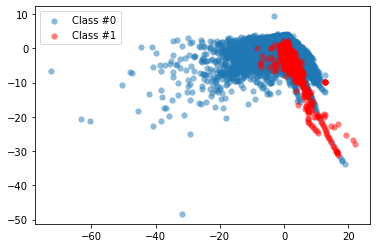

In [28]:
plt.scatter(df.V2[df.Class == 0], df.V3[df.Class == 0], label="Class #0", alpha=0.5, linewidth=0.15)
plt.scatter(df.V2[df.Class == 1], df.V3[df.Class == 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
plt.legend()
plt.show()

# SMOTE

In [29]:
# Run the prep_data function
X, y = prep_data(df)

In [30]:
print(f'X shape: {X.shape}\ny shape: {y.shape}')

X shape: (284807, 28)
y shape: (284807,)


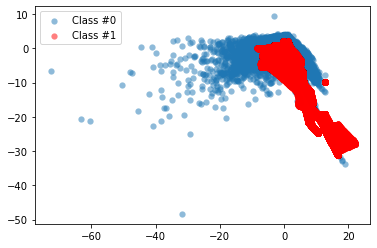

In [32]:
# Define the resampling method
method = SMOTE()

# Create the resampled feature set
X_resampled, y_resampled = method.fit_resample(X, y)

# Plot the resampled data
plot_data(X_resampled, y_resampled)

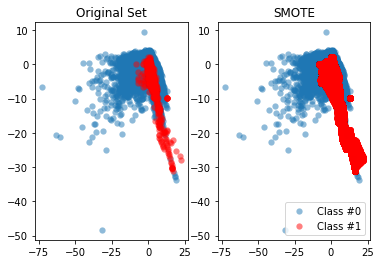

In [33]:
compare_plot(X, y, X_resampled, y_resampled, method='SMOTE')

# Logistic Regression

In [34]:
# Split the features and labels into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit a logistic regression model to our data
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

# Obtain model predictions
predicted = model.predict(X_test)

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.86      0.70      0.77        87

    accuracy                           1.00     56962
   macro avg       0.93      0.85      0.89     56962
weighted avg       1.00      1.00      1.00     56962

Confusion matrix:
 [[56865    10]
 [   26    61]]


# Random forrest

In [35]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X_train, y_train)
predicted = model.predict(X_test)
print(f'Accuracy Score:\n{accuracy_score(y_test, predicted)}')

Accuracy Score:
0.9995786664794073


In [36]:
# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.92      0.79      0.85        87

    accuracy                           1.00     56962
   macro avg       0.96      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962

Confusion matrix:
 [[56869     6]
 [   18    69]]
